## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
!nvidia-smi

Sun Dec 12 06:51:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     - 10.4 MB 1.3 MB/s
     |████████████████████████████████| 180 kB 8.1 MB/s 
     |████████████████████████████████| 76 kB 5.9 MB/s 
     |████████████████████████████████| 140 kB 62.5 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 70 kB 9.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=be447d25f99a974d88f1a2e1981f7dde6efd79b4b27e85162f7762dfe9696550
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=07fd6717cc23f55fbc5e79a39c99723313728c2beb36aa9bcde9695dae263df8
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=3b9b91ed6905af47574470aa51e44

In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [6]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [30]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
#Testing images
test_images=list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images))
print(len(test_images))

1250
250


In [8]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [9]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [10]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [11]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Utilities

In [12]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [16]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-12-12 07:15:15--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.2’

helpers.py.2        100%[===================>]     891  --.-KB/s    in 0s      

2021-12-12 07:15:15 (55.5 MB/s) - ‘helpers.py.2’ saved [891/891]

--2021-12-12 07:15:15--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

Don't forget to comment the `augmentation` import in the `helpers.py` script.

In [18]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [19]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [20]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [21]:
wandb.init(project="simclr")

wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/shashank-89/simclr/runs/11aurgh3

In [22]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [00:31<1:45:52, 31.92s/it]

epoch: 1 loss: 4.848


  6%|▌         | 11/200 [02:49<43:18, 13.75s/it]

epoch: 11 loss: 4.143


 10%|█         | 21/200 [05:04<40:14, 13.49s/it]

epoch: 21 loss: 3.619


 16%|█▌        | 31/200 [07:21<38:26, 13.65s/it]

epoch: 31 loss: 3.168


 20%|██        | 41/200 [09:36<35:42, 13.48s/it]

epoch: 41 loss: 2.802


 26%|██▌       | 51/200 [11:52<33:45, 13.59s/it]

epoch: 51 loss: 2.532


 30%|███       | 61/200 [14:08<31:32, 13.61s/it]

epoch: 61 loss: 2.381


 36%|███▌      | 71/200 [16:30<33:40, 15.66s/it]

epoch: 71 loss: 2.227


 40%|████      | 81/200 [18:47<27:01, 13.63s/it]

epoch: 81 loss: 2.143


 46%|████▌     | 91/200 [21:02<24:34, 13.53s/it]

epoch: 91 loss: 2.073


 50%|█████     | 101/200 [23:17<22:19, 13.53s/it]

epoch: 101 loss: 2.000


 56%|█████▌    | 111/200 [25:40<20:16, 13.66s/it]

epoch: 111 loss: 1.948


 60%|██████    | 121/200 [27:55<17:50, 13.55s/it]

epoch: 121 loss: 1.900


 66%|██████▌   | 131/200 [30:11<15:41, 13.65s/it]

epoch: 131 loss: 1.858


 70%|███████   | 141/200 [32:27<13:20, 13.57s/it]

epoch: 141 loss: 1.825


 76%|███████▌  | 151/200 [34:43<11:08, 13.65s/it]

epoch: 151 loss: 1.792


 80%|████████  | 161/200 [36:59<08:49, 13.56s/it]

epoch: 161 loss: 1.769


 86%|████████▌ | 171/200 [39:15<06:33, 13.57s/it]

epoch: 171 loss: 1.754


 90%|█████████ | 181/200 [41:31<04:17, 13.57s/it]

epoch: 181 loss: 1.743


 96%|█████████▌| 191/200 [43:46<02:02, 13.56s/it]

epoch: 191 loss: 1.731


100%|██████████| 200/200 [45:48<00:00, 13.74s/it]


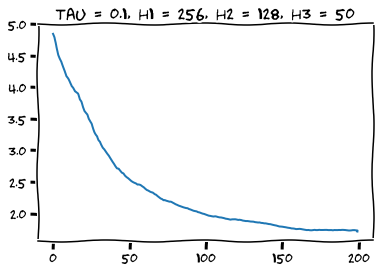

In [23]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [32]:
from sklearn.preprocessing import LabelEncoder
def prepare_images(image_paths):
    images = []
    labels = []
    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.
        label = image.split("/")[2].split("_")[0]
        images.append(image_pixels)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    print(images.shape, labels.shape)
    return images, labels

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

100%|██████████| 1250/1250 [00:05<00:00, 238.19it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 227.65it/s]


(250, 224, 224, 3) (250,)


In [33]:
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [35]:
def plot_training(H):
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()



resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)
print(train_features.shape, test_features.shape)
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

Epoch 1/35
20/20 [==============================] - 1s 10ms/step - loss: 4.1924 - accuracy: 0.2184 - val_loss: 3.0771 - val_accuracy: 0.1920
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 2.8107 - accuracy: 0.2496 - val_loss: 2.2115 - val_accuracy: 0.2720
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 2.1347 - accuracy: 0.3120 - val_loss: 1.7771 - val_accuracy: 0.3480
Epoch 4/35
20/20 [==============================] - 0s 4ms/step - loss: 1.7943 - accuracy: 0.3768 - val_loss: 1.5450 - val_accuracy: 0.4160
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.6066 - accuracy: 0.4160 - val_loss: 1.4128 - val_accuracy: 0.4600
Epoch 6/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4833 - accuracy: 0.4432 - val_loss: 1.3398 - val_accuracy: 0.5120
Epoch 7/35
20/20 [==============================] - 0s 4ms/step - loss: 1.3983 - accuracy: 0.4744 - val_loss: 1.2849 - val_accuracy: 0.5120
Epoch 8/35
20/20 [=

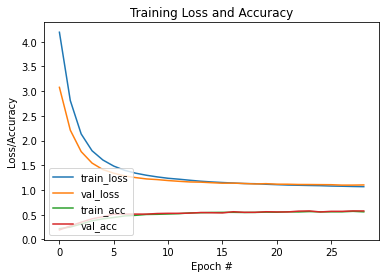

In [36]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,validation_data=(test_features, y_test_enc),batch_size=64,epochs=35,callbacks=[es])
plot_training(history)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


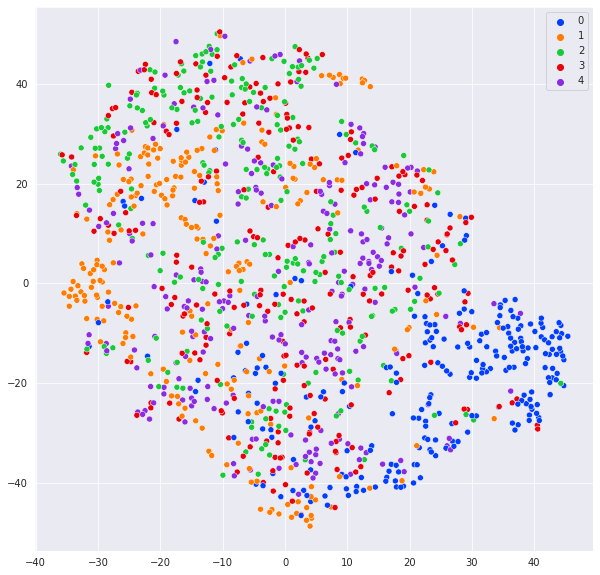

In [39]:
from sklearn.manifold import TSNE
import seaborn as sns
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()
    return fig



# Representations with linear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

In [27]:
resnet_simclr.save_weights(filename)
wandb.save(filename)

wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/content/wandb/run-20211212_071538-11aurgh3/20211212-080406resnet_simclr.h5']